<ipython-input-1-eefde58f1d80>:29: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_data['rul'] = train_data.groupby('unit_number')['time_cycles'].transform(max) - train_data['time_cycles']


Test RMSE: 86.39 cycles
Test R2 Score: -3.36

Feature Importance:
         feature  importance
9      sensor_11    0.584753
8       sensor_9    0.143059
5       sensor_4    0.099066
10     sensor_12    0.034096
6       sensor_7    0.023939
12     sensor_14    0.021507
13     sensor_15    0.017276
16     sensor_21    0.014625
3       sensor_2    0.010802
4       sensor_3    0.010662
11     sensor_13    0.010457
7       sensor_8    0.009233
15     sensor_20    0.008907
0   op_setting_1    0.005485
14     sensor_17    0.003447
1   op_setting_2    0.002686
2   op_setting_3    0.000000


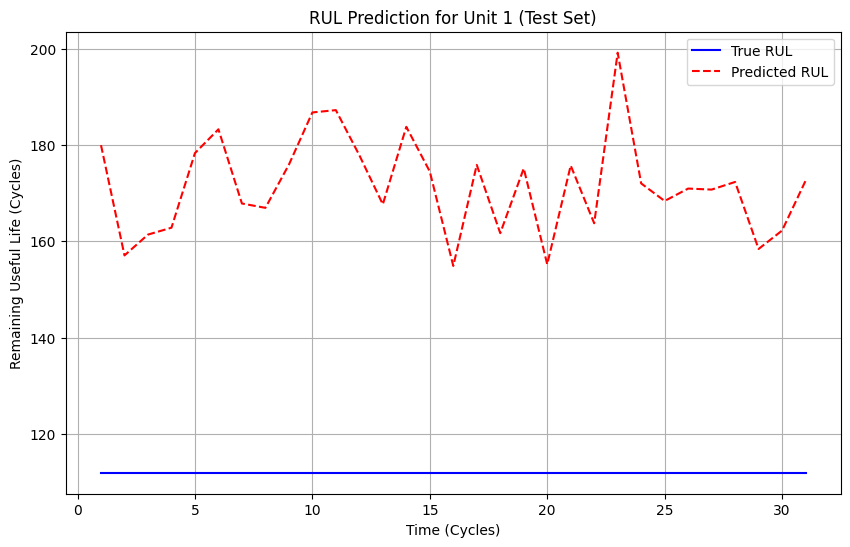

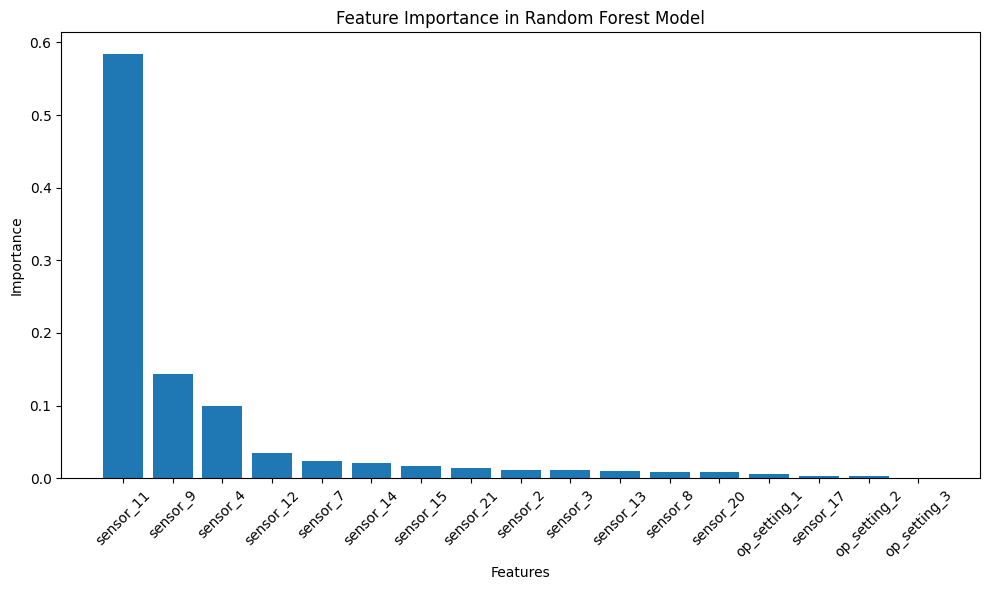


Predictions saved to 'cmapss_predictions.csv'.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# ------------------------------
# 1. Load and Preprocess Data
# ------------------------------

# Define column names (based on CMAPSS documentation)
columns = ['unit_number', 'time_cycles'] + \
          [f'op_setting_{i}' for i in range(1, 4)] + \
          [f'sensor_{i}' for i in range(1, 22)]

# Load training data
train_data = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=columns)

# Load test data and RUL
test_data = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=columns)
test_rul = pd.read_csv('RUL_FD001.txt', header=None, names=['rul'])

# Calculate RUL for training data
# RUL = max_cycles - current_cycle for each unit
train_data['rul'] = train_data.groupby('unit_number')['time_cycles'].transform(max) - train_data['time_cycles']

# For test data, assign true RUL (from RUL_FD001.txt) to the last cycle of each unit
test_units = test_data.groupby('unit_number').last().reset_index()
test_units['rul'] = test_rul['rul']
test_data = test_data.merge(test_units[['unit_number', 'rul']], on='unit_number', how='left')

# Feature selection: Exclude constant or low-variance sensors
# Based on domain knowledge and exploratory analysis, some sensors are noisy or constant
features = ['op_setting_1', 'op_setting_2', 'op_setting_3'] + \
           ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
            'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
            'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']
target = 'rul'

# Filter data
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Handle missing values (if any)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 2. Train Predictive Maintenance Model
# ------------------------------

# Initialize and train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

# Predict RUL on test set
y_pred = model.predict(X_test_scaled)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f} cycles")
print(f"Test R2 Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# ------------------------------
# 3. Visualization
# ------------------------------

# Plot actual vs predicted RUL for a sample unit
sample_unit = test_data[test_data['unit_number'] == 1]
sample_X = scaler.transform(sample_unit[features])
sample_y_pred = model.predict(sample_X)
sample_y_true = sample_unit['rul']

plt.figure(figsize=(10, 6))
plt.plot(sample_unit['time_cycles'], sample_y_true, label='True RUL', color='blue')
plt.plot(sample_unit['time_cycles'], sample_y_pred, label='Predicted RUL', color='red', linestyle='--')
plt.title('RUL Prediction for Unit 1 (Test Set)')
plt.xlabel('Time (Cycles)')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.legend()
plt.grid(True)
plt.show()

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ------------------------------
# 4. Save Model and Results
# ------------------------------

# Save predictions
results = pd.DataFrame({
    'unit_number': test_data['unit_number'],
    'time_cycles': test_data['time_cycles'],
    'true_rul': y_test,
    'predicted_rul': y_pred
})
results.to_csv('cmapss_predictions.csv', index=False)
print("\nPredictions saved to 'cmapss_predictions.csv'.")

<ipython-input-2-41b2e236d2bd>:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_numerical = data[numerical_cols].resample('H').mean()
<ipython-input-2-41b2e236d2bd>:35: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_categorical = data[categorical_cols].resample('H').agg(lambda x: x.mode()[0] if not x.empty else np.nan)
<ipython-input-2-41b2e236d2bd>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6rpo55al/ec3jpref.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6rpo55al/utrksoai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36048', 'data', 'file=/tmp/

Test MAPE: 9.6352
Test RMSE: 65.36 kWh

Future Forecast Sample:
                   ds       yhat  energy_cost
0 2019-01-01 00:00:00  51.390305     7.708546
1 2019-01-01 01:00:00  46.671270     7.000690
2 2019-01-01 02:00:00  50.036023     7.505404
3 2019-01-01 03:00:00  53.345136     8.001770
4 2019-01-01 04:00:00  51.346931     7.702040


<ipython-input-2-41b2e236d2bd>:88: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1),


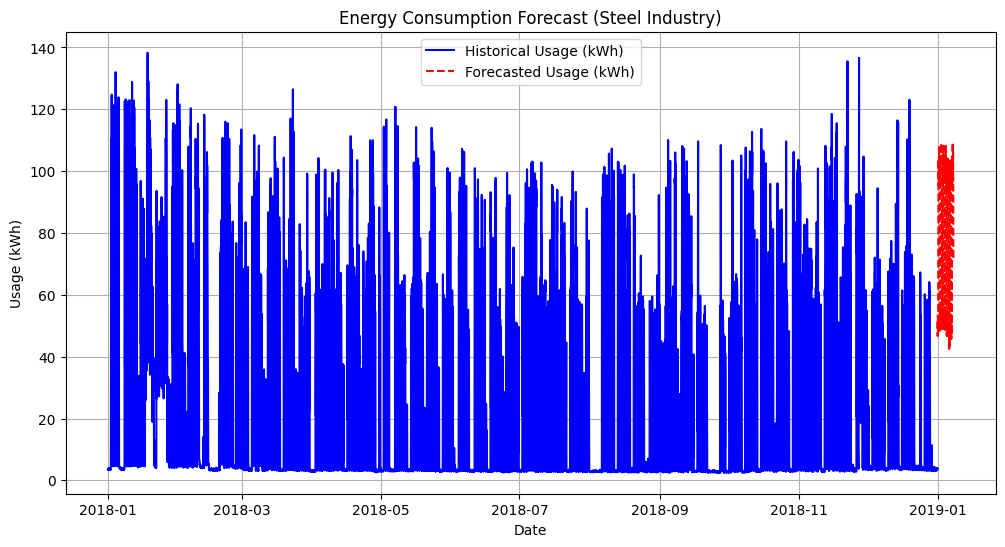

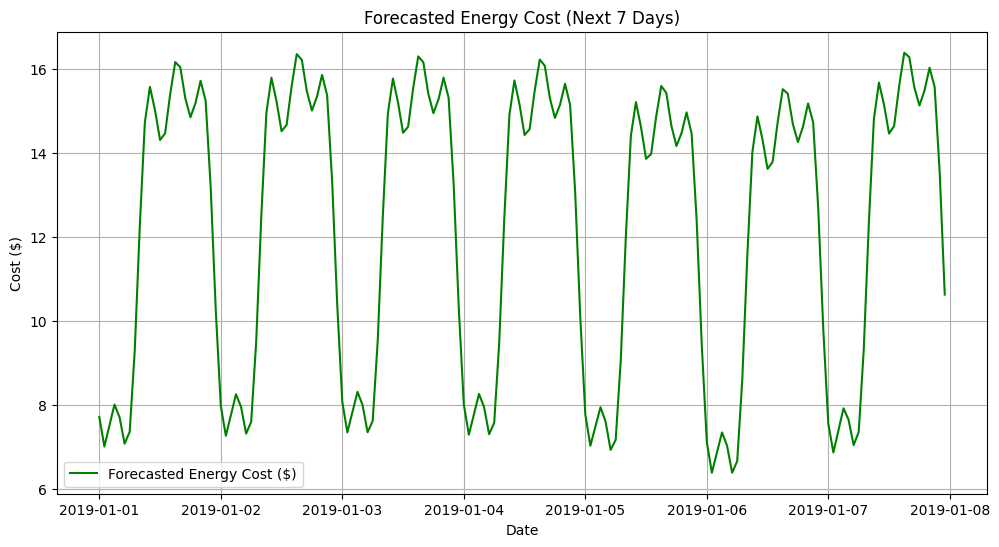


Forecast saved to 'steel_energy_forecast.csv'.


In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# ------------------------------
# 1. Load and Preprocess Data
# ------------------------------

# Load dataset
try:
    data = pd.read_csv('Steel_industry_data.csv')
except FileNotFoundError:
    print("Error: 'Steel_industry_dataset.csv' not found in 'data/' folder. Please ensure the file exists.")
    exit(1)

# Convert date to datetime
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y %H:%M', errors='coerce')
if data['date'].isna().any():
    print("Warning: Some dates could not be parsed. Check date format in CSV.")

# Resample to hourly data
data = data.set_index('date')
numerical_cols = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
                  'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
                  'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM']
categorical_cols = ['WeekStatus', 'Day_of_week', 'Load_Type']

# Aggregate numerical and categorical columns
data_numerical = data[numerical_cols].resample('H').mean()
data_categorical = data[categorical_cols].resample('H').agg(lambda x: x.mode()[0] if not x.empty else np.nan)
data = pd.concat([data_numerical, data_categorical], axis=1).reset_index()

# Handle missing values
data = data.fillna(method='ffill')

# Prepare data for Prophet
prophet_data = data.rename(columns={'date': 'ds', 'Usage_kWh': 'y'})

# Encode categorical variables
prophet_data = pd.get_dummies(prophet_data, columns=['WeekStatus', 'Day_of_week', 'Load_Type'], drop_first=True)

# Select regressors
regressors = ['Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM'] + \
             [col for col in prophet_data.columns if col.startswith(('WeekStatus_', 'Day_of_week_', 'Load_Type_'))]

# ------------------------------
# 2. Train Energy Forecasting Model
# ------------------------------

# Split data
train_size = int(0.8 * len(prophet_data))
train_data = prophet_data.iloc[:train_size]
test_data = prophet_data.iloc[train_size:]

# Initialize and train Prophet model
model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
for regressor in regressors:
    model.add_regressor(regressor)
model.fit(train_data[['ds', 'y'] + regressors])

# ------------------------------
# 3. Evaluate Model
# ------------------------------

# Predict on test set
future = test_data[['ds'] + regressors]
forecast = model.predict(future)

# Metrics
y_true = test_data['y']
y_pred = forecast['yhat']
mape = mean_absolute_percentage_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.2f} kWh")

# ------------------------------
# 4. Forecast Future Energy Consumption
# ------------------------------

# Create future dataframe
last_date = prophet_data['ds'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1),
                             periods=168, freq='H')  # 7 days
future_df = pd.DataFrame({'ds': future_dates})

# Populate regressors (use last known values)
for regressor in regressors:
    future_df[regressor] = prophet_data[regressor].iloc[-1]

# Forecast
future_forecast = model.predict(future_df)

# Add energy cost
future_forecast['energy_cost'] = future_forecast['yhat'] * 0.15  # $0.15/kWh

# Debug: Check future_forecast
print("\nFuture Forecast Sample:")
print(future_forecast[['ds', 'yhat', 'energy_cost']].head())
if future_forecast.empty:
    print("Error: future_forecast is empty. Check date range or data filtering.")
    exit(1)

# ------------------------------
# 5. Visualization
# ------------------------------

# Plot historical and forecasted energy consumption
plt.figure(figsize=(12, 6))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Usage (kWh)', color='blue')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecasted Usage (kWh)', color='red', linestyle='--')
plt.title('Energy Consumption Forecast (Steel Industry)')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# Plot forecasted energy cost
plt.figure(figsize=(12, 6))
plt.plot(future_forecast['ds'], future_forecast['energy_cost'], label='Forecasted Energy Cost ($)', color='green')
plt.title('Forecasted Energy Cost (Next 7 Days)')
plt.xlabel('Date')
plt.ylabel('Cost ($)')
plt.legend()
plt.grid(True)
plt.show()

# ------------------------------
# 6. Save Results
# ------------------------------

future_forecast[['ds', 'yhat', 'energy_cost']].to_csv('steel_energy_forecast.csv', index=False)
print("\nForecast saved to 'steel_energy_forecast.csv'.")

In [ ]:
# Load CMAPSS predictions
cmapss_preds = pd.read_csv('cmapss_predictions.csv')
cmapss_preds['timestamp'] = pd.date_range(start='2018-01-01 00:00:00',
                                          periods=len(cmapss_preds), freq='H')

# Load steel forecast
steel_forecast = pd.read_csv('steel_energy_forecast.csv')
steel_forecast['ds'] = pd.to_datetime(steel_forecast['ds'])

# Merge
combined_data = pd.merge_asof(
    cmapss_preds.sort_values('timestamp'),
    steel_forecast.sort_values('ds'),
    left_on='timestamp',
    right_on='ds',
    direction='nearest'
)

# Optimization
maintenance_schedule = combined_data[combined_data['predicted_rul'] < 30][['ds', 'predicted_rul', 'energy_cost']]
maintenance_schedule = maintenance_schedule.sort_values('energy_cost')
maintenance_schedule.to_csv('integrated_schedule.csv', index=False)
print("\nIntegrated Maintenance Schedule:")
print(maintenance_schedule.head())


Integrated Maintenance Schedule:
             ds  predicted_rul  energy_cost
2429 2019-01-01      18.183840     7.708546
2430 2019-01-01      19.875590     7.708546
2431 2019-01-01      28.614899     7.708546
2432 2019-01-01      20.415098     7.708546
2433 2019-01-01      10.802274     7.708546


<ipython-input-3-2b3cc82ec56e>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cmapss_preds['timestamp'] = pd.date_range(start='2018-01-01 00:00:00',


In [ ]:
from pyngrok import ngrok
!ngrok authtoken 2wCiA8CYQsppibCB1UH45YFyfGn_7nWDQQnXZ8yr41C4YRZRk  # Replace with your ngrok authtoken

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
%%writefile realtime_dashboard_colab.py
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from prophet import Prophet
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import logging
import os
from pyngrok import ngrok
import time

# Set up logging
logging.basicConfig(level=logging.INFO, filename='streamlit_debug.log',
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set random seed for reproducibility
np.random.seed(42)

# ------------------------------
# 1. Generate Synthetic Dataset
# ------------------------------

def generate_synthetic_pdm_data(n_hours=1000, n_units=5):
    """Generate synthetic PdM data mimicking CMAPSS."""
    start_time = pd.to_datetime('2025-04-01 00:00:00')
    timestamps = pd.date_range(start=start_time, periods=n_hours, freq='h')
    data = []

    for unit in range(1, n_units + 1):
        cycles = np.arange(1, n_hours + 1)
        max_life = np.random.randint(100, 200)
        rul = np.maximum(max_life - cycles, 0) + np.random.normal(0, 5, n_hours)

        vibration = np.random.normal(0.5, 0.1, n_hours) + (max_life - rul) * 0.01
        temperature = np.random.normal(70, 5, n_hours) + (max_life - rul) * 0.05
        pressure = np.random.normal(100, 10, n_hours) + (max_life - rul) * 0.02

        unit_data = pd.DataFrame({
            'unit_number': unit,
            'time_cycles': cycles,
            'ds': timestamps,
            'vibration': vibration,
            'temperature': temperature,
            'pressure': pressure,
            'rul': rul
        })
        data.append(unit_data)

    return pd.concat(data, ignore_index=True)

def generate_synthetic_energy_data(n_hours=1000):
    """Generate synthetic energy data mimicking Steel Industry Dataset."""
    start_time = pd.to_datetime('2025-04-01 00:00:00')
    timestamps = pd.date_range(start=start_time, periods=n_hours, freq='h')

    hours = np.arange(n_hours)
    usage_kwh = 50 + 20 * np.sin(2 * np.pi * hours / 24) + np.random.normal(0, 5, n_hours)

    lagging_power_factor = np.random.normal(0.9, 0.05, n_hours)
    load_type = np.where(usage_kwh < 60, 'Light_Load',
                         np.where(usage_kwh < 80, 'Medium_Load', 'Heavy_Load'))

    return pd.DataFrame({
        'ds': timestamps,
        'Usage_kWh': usage_kwh,
        'Lagging_Power_Factor': lagging_power_factor,
        'Load_Type': load_type
    })

# Generate initial datasets
pdm_data = generate_synthetic_pdm_data()
energy_data = generate_synthetic_energy_data()

# Save for reference
pdm_data.to_csv('synthetic_pdm_data.csv', index=False)
energy_data.to_csv('synthetic_energy_data.csv', index=False)
logger.info("Synthetic datasets generated and saved.")

# ------------------------------
# 2. Train Models
# ------------------------------

# PdM Model (Random Forest)
features = ['vibration', 'temperature', 'pressure']
X_pdm = pdm_data[features]
y_pdm = pdm_data['rul']
pdm_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
pdm_model.fit(X_pdm, y_pdm)
logger.info("PdM model trained.")

# Energy Forecasting Model (Prophet)
prophet_data = energy_data.rename(columns={'Usage_kWh': 'y'})
prophet_data['Load_Type'] = pd.Categorical(prophet_data['Load_Type'],
                                          categories=['Light_Load', 'Medium_Load', 'Heavy_Load'])
prophet_data = pd.get_dummies(prophet_data, columns=['Load_Type'], drop_first=True)

for col in ['Load_Type_Medium_Load', 'Load_Type_Heavy_Load']:
    if col not in prophet_data:
        prophet_data[col] = 0

energy_model = Prophet(daily_seasonality=True, weekly_seasonality=True)
energy_model.add_regressor('Lagging_Power_Factor')
energy_model.add_regressor('Load_Type_Medium_Load')
energy_model.add_regressor('Load_Type_Heavy_Load')
energy_model.fit(prophet_data[['ds', 'y', 'Lagging_Power_Factor',
                              'Load_Type_Medium_Load', 'Load_Type_Heavy_Load']])
logger.info("Energy model trained.")

# ------------------------------
# 3. Real-Time Simulation and Streamlit Dashboard
# ------------------------------

def simulate_real_time_data(current_time, unit=1):
    """Simulate new data point for a given time with controlled RUL degradation."""
    st.session_state.unit_cycles[unit] += 1
    cycle = st.session_state.unit_cycles[unit]

    # Standard max_life for all units
    max_life = 40
    # Controlled degradation: start at ~40, drop to <30 by cycle 10
    if cycle == 1:
        rul = 40 + np.random.normal(0, 1)  # Start fine (RUL ~40)
    else:
        rul = max(40 - cycle * 1.5, 0) + np.random.normal(0, 1)  # Linear degradation
    rul = max(rul, 0)  # Ensure non-negative

    vibration = np.random.normal(0.5, 0.1) + (max_life - rul) * 0.01
    temperature = np.random.normal(70, 5) + (max_life - rul) * 0.05
    pressure = np.random.normal(100, 10) + (max_life - rul) * 0.02

    pdm_point = pd.DataFrame({
        'unit_number': [unit],
        'time_cycles': [cycle],
        'ds': [current_time],
        'vibration': [vibration],
        'temperature': [temperature],
        'pressure': [pressure],
        'rul': [rul]
    })

    hour = (current_time - pd.to_datetime('2025-04-01')).total_seconds() / 3600
    usage_kwh = 50 + 20 * np.sin(2 * np.pi * hour / 24) + np.random.normal(0, 2)
    lagging_power_factor = np.random.normal(0.9, 0.05)
    load_type = 'Light_Load' if usage_kwh < 60 else 'Medium_Load' if usage_kwh < 80 else 'Heavy_Load'

    energy_point = pd.DataFrame({
        'ds': [current_time],
        'Usage_kWh': [usage_kwh],
        'Lagging_Power_Factor': [lagging_power_factor],
        'Load_Type': [load_type]
    })
    energy_point['Load_Type'] = pd.Categorical(energy_point['Load_Type'],
                                              categories=['Light_Load', 'Medium_Load', 'Heavy_Load'])
    energy_point = pd.get_dummies(energy_point, columns=['Load_Type'], drop_first=True)
    for col in ['Load_Type_Medium_Load', 'Load_Type_Heavy_Load']:
        if col not in energy_point:
            energy_point[col] = 0

    logger.info(f"Unit {unit}: cycle={cycle}, max_life={max_life}, rul={rul:.2f}, kwh={usage_kwh:.2f}")
    return pdm_point, energy_point

# Initialize session state
if 'current_time' not in st.session_state:
    st.session_state.current_time = pd.to_datetime('2025-04-01 00:00:00')
if 'pdm_stream' not in st.session_state:
    st.session_state.pdm_stream = pd.DataFrame(columns=['unit_number', 'time_cycles', 'ds',
                                                        'vibration', 'temperature', 'pressure', 'rul'])
if 'energy_stream' not in st.session_state:
    st.session_state.energy_stream = pd.DataFrame(columns=['ds', 'Usage_kWh', 'Lagging_Power_Factor',
                                                           'Load_Type_Medium_Load', 'Load_Type_Heavy_Load'])
if 'unit_cycles' not in st.session_state:
    st.session_state.unit_cycles = {unit: 0 for unit in range(1, 6)}
if 'iteration' not in st.session_state:
    st.session_state.iteration = 0
if 'simulate' not in st.session_state:
    st.session_state.simulate = True

# Streamlit dashboard
st.title("PredictPulse: Real-Time Manufacturing Dashboard")
logger.info("Streamlit dashboard initialized.")

# Placeholders for dynamic updates
alert_placeholder = st.empty()
pdm_plot = st.empty()
energy_plot = st.empty()
schedule_table = st.empty()
rul_display = st.empty()

# Stop simulation button
with st.container():
    st.write("Control Simulation:")
    if st.button("Stop Simulation"):
        st.session_state.simulate = False
        st.write("Simulation stopped.")

# Automatic simulation loop
max_iterations = 20  # Limit for Colab
while st.session_state.simulate and st.session_state.iteration < max_iterations:
    try:
        current_time = st.session_state.current_time
        # Simulate data for units 1–3
        for unit in range(1, 4):
            pdm_point, energy_point = simulate_real_time_data(current_time, unit)

            logger.info(f"Iteration {st.session_state.iteration}, Unit {unit}: pdm_stream columns: {st.session_state.pdm_stream.columns.tolist()}")
            logger.info(f"pdm_point:\n{pdm_point.to_string()}")

            st.session_state.pdm_stream = pd.concat([st.session_state.pdm_stream, pdm_point], ignore_index=True)
            if unit == 1:  # Append energy data once per iteration
                st.session_state.energy_stream = pd.concat([st.session_state.energy_stream, energy_point], ignore_index=True)

        # Generate energy forecast for the next 24 hours
        future_dates = pd.date_range(start=current_time, periods=24, freq='h')
        future_df = pd.DataFrame({'ds': future_dates})
        future_df['Lagging_Power_Factor'] = energy_point['Lagging_Power_Factor'].iloc[0]
        future_df['Load_Type_Medium_Load'] = energy_point['Load_Type_Medium_Load'].iloc[0]
        future_df['Load_Type_Heavy_Load'] = energy_point['Load_Type_Heavy_Load'].iloc[0]
        forecast = energy_model.predict(future_df)
        forecast['energy_cost'] = forecast['yhat'] * 0.15

        # Process maintenance alerts
        pdm_latest = st.session_state.pdm_stream[st.session_state.pdm_stream['ds'] == current_time]
        logger.info(f"pdm_latest:\n{pdm_latest[['unit_number', 'rul']].to_string()}")
        maintenance_alerts = []
        for _, row in pdm_latest.iterrows():
            X_latest = row[features].values.reshape(1, -1)
            predicted_rul = pdm_model.predict(X_latest)[0]
            if row['rul'] < 30:  # Use simulated RUL for alerting
                low_cost_periods = forecast[forecast['energy_cost'] == forecast['energy_cost'].min()]
                maintenance_alerts.append({
                    'ds': low_cost_periods['ds'].iloc[0],
                    'unit_number': int(row['unit_number']),
                    'simulated_rul': row['rul'],
                    'predicted_rul': predicted_rul,
                    'energy_cost': low_cost_periods['energy_cost'].iloc[0]
                })
                logger.info(f"Maintenance alert triggered for Unit {row['unit_number']}: simulated_rul={row['rul']:.2f}, predicted_rul={predicted_rul:.2f}")

        # Update dashboard
        with alert_placeholder.container():
            if maintenance_alerts:
                for alert in maintenance_alerts:
                    alert_msg = f"🚨 Maintenance Alert: Unit {alert['unit_number']} needs maintenance at {alert['ds']} (Simulated RUL: {alert['simulated_rul']:.1f}, Predicted RUL: {alert['predicted_rul']:.1f}, Cost: ${alert['energy_cost']:.2f})"
                    st.error(alert_msg)
                    with open('maintenance_alerts.txt', 'a') as f:
                        f.write(f"{current_time}: {alert_msg}\n")
            else:
                st.success("✅ No maintenance required.")

        with pdm_plot.container():
            fig, ax = plt.subplots(figsize=(10, 4))
            for unit in range(1, 4):
                unit_data = st.session_state.pdm_stream[st.session_state.pdm_stream['unit_number'] == unit]
                ax.plot(unit_data['ds'], unit_data['rul'], label=f'Unit {unit}')
            ax.axhline(30, color='red', linestyle='--', label='Maintenance Threshold')
            ax.set_title('Real-Time RUL Monitoring')
            ax.set_xlabel('Time')
            ax.set_ylabel('RUL (Cycles)')
            ax.legend()
            ax.grid(True)
            st.pyplot(fig)
            fig.savefig(f'rul_plot_{st.session_state.iteration}.png')

        with energy_plot.container():
            fig, ax = plt.subplots(figsize=(10, 4))
            ax.plot(st.session_state.energy_stream['ds'], st.session_state.energy_stream['Usage_kWh'], label='Usage (kWh)', color='blue')
            ax.plot(forecast['ds'], forecast['yhat'], label='Forecast (kWh)', color='red', linestyle='--')
            ax.set_title('Real-Time Energy Consumption and Forecast')
            ax.set_xlabel('Time')
            ax.set_ylabel('Usage (kWh)')
            ax.legend()
            ax.grid(True)
            st.pyplot(fig)
            fig.savefig(f'energy_plot_{st.session_state.iteration}.png')

        with schedule_table.container():
            if maintenance_alerts:
                st.write("Maintenance Schedule")
                st.dataframe(pd.DataFrame(maintenance_alerts))
                pd.DataFrame(maintenance_alerts).to_csv('maintenance_schedule.csv', mode='a',
                                                        header=not os.path.exists('maintenance_schedule.csv'), index=False)

        with rul_display.container():
            st.write("Current RUL Values:")
            for unit in range(1, 4):
                unit_data = st.session_state.pdm_stream[st.session_state.pdm_stream['unit_number'] == unit]
                if not unit_data.empty:
                    latest_rul = unit_data['rul'].iloc[-1]
                    X_latest = unit_data[features].iloc[-1].values.reshape(1, -1)
                    predicted_rul = pdm_model.predict(X_latest)[0]
                    st.write(f"Unit {unit}: Simulated RUL = {latest_rul:.1f} cycles, Predicted RUL = {predicted_rul:.1f} cycles")

        st.session_state.current_time += timedelta(hours=1)
        st.session_state.iteration += 1
        logger.info(f"Iteration {st.session_state.iteration} completed. Current time: {current_time}")

        time.sleep(3)  # Simulate real-time delay (3 seconds per hour)
        st.rerun()  # Refresh dashboard

    except Exception as e:
        logger.error(f"Error in iteration {st.session_state.iteration}: {str(e)}")
        st.error(f"Error: {str(e)}. Check streamlit_debug.log for details.")
        st.session_state.simulate = False
        break

Writing realtime_dashboard_colab.py


In [10]:
import os
from pyngrok import ngrok

#Run Streamlit in the background
os.system("streamlit run realtime_dashboard_colab.py &")

#Create a tunnel to port 8501
public_url = ngrok.connect(8501)
print(f"Streamlit URL: {public_url}")

Streamlit URL: NgrokTunnel: "https://519b-34-31-149-153.ngrok-free.app" -> "http://localhost:8501"
